# Diary for CRBM implementation



This notebook shows the parts from `crbm.py` with some details

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import inspect
import json
import pickle

import random
import numpy as np 
import pandas as pd
import numexpr as ne
import sklearn
from sklearn import preprocessing
from matplotlib import pyplot as plt 

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import tstools
from tstools import timeseries  

import Datasets
from Datasets import al_series



##### read data from  `../Datasets/motion.mat`

More data from human motion captures can be found here:

http://people.csail.mit.edu/ehsu/work/sig05stf/

In [2]:
#############################
## MOTION DATA ##############
#############################

#from scipy.io import loadmat  # this is the SciPy module that loads mat-files
#data = loadmat('../Datasets/motion.mat')
#X1 = data["Motion"][0][0]
#X2 = data["Motion"][0][1]
#X3 = data["Motion"][0][2]
#data.keys()
# X1.shape, X2.shape, X2.shape

# n_features = X1.shape[1]
# for f in range(n_features):
#     max_val, min_val =  X1[:, f].max(), X1[:, f].min()
#     if (max_val - min_val) != 0:
#         X1[:, f] = ( X1[:, f]  - min_val)  / (max_val - min_val)
#     else:
#         #print(f, max_val, max_val)
#         X1[:, f] = ( X1[:, f]  - min_val) # / (max_val - min_val)


In [3]:
#from path import path

my_path = '../Datasets/al_series/'

files = os.walk(my_path)

X = []

for root, dirs, files in files:
    for f in files:
        x = pd.read_csv(os.path.join(root, f), index_col="Unnamed: 0")
        X.append(x.as_matrix())

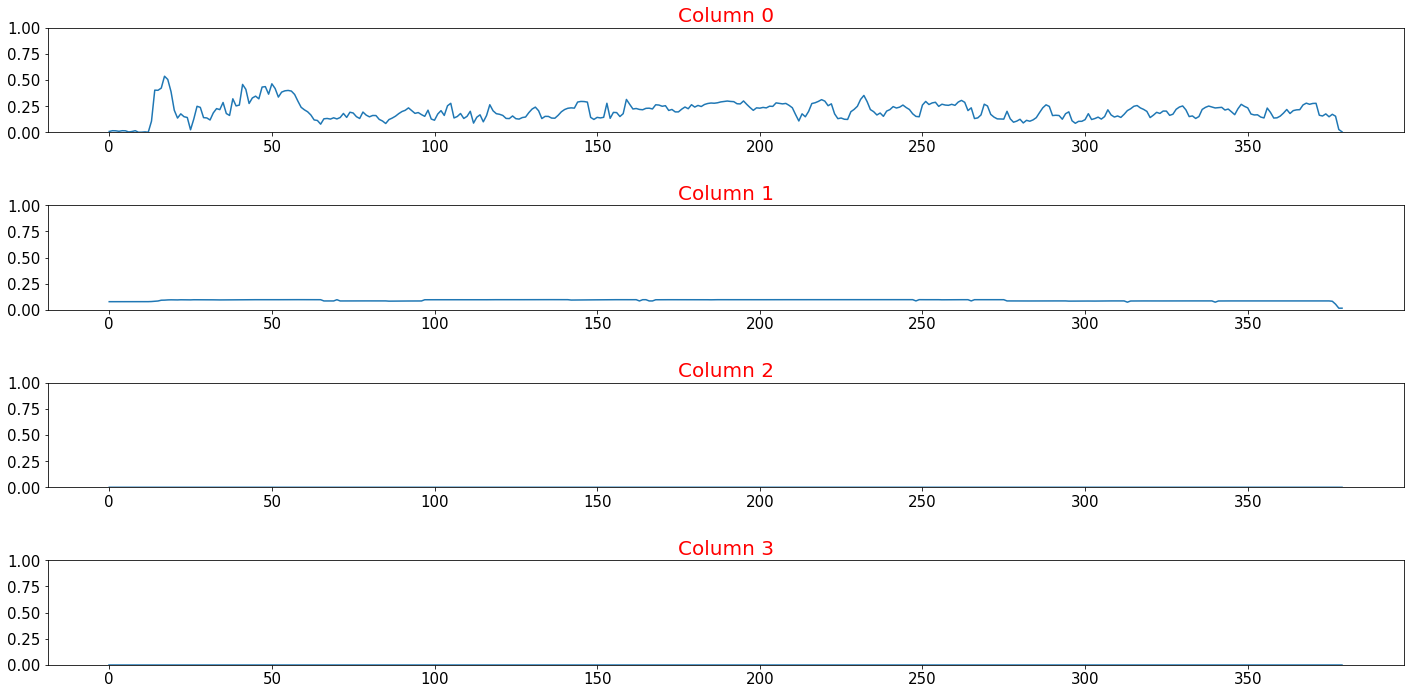

In [4]:
timeseries.plot_timeseries(X[-8])

In [5]:
X_train = X[0:-8]
X_test = X[-8:]
len(X_train), len(X_test),len(X)

(24, 8, 32)

In [6]:
n_feat = X_train[0].shape[1]
n_feat

4


### Generate train slices

We can create, given `n_vis` and `n_his`, a list containing all the slices of those proportions from our timeseries. This will be used for learning.

In [7]:
X_train[0].shape

(501, 4)

In [8]:
def build_slices_from_list_of_arrays(list_of_arrays, n_his, n_feat):
    """
    This function creates a list of slices of shape (n_his + 1, n_feat)
    """
    assert list_of_arrays[0].shape[1] == n_feat, "list_of_arrays[0].shape[1]={} but n_feat={}".format( list_of_arrays[0].shape[1], n_feat)
    
    X_slices = []
    
    for m, arr in enumerate(list_of_arrays):
        if arr.shape[0] < n_his + 1:
            print("Sequence {} has length {}".format(m, arr.shape[0])) 
        else:
            for k in range(n_his+1, arr.shape[0] + 1):
                X_slice = arr[(k-n_his-1):k, :]
                if X_slice.shape[0] != n_his+1:
                    print("error!")
                X_slices.append(X_slice)
                
    return X_slices

In [9]:
X_train[0][0:20].shape

(20, 4)

In [10]:
X_slices = build_slices_from_list_of_arrays(X_train, 20, n_feat)

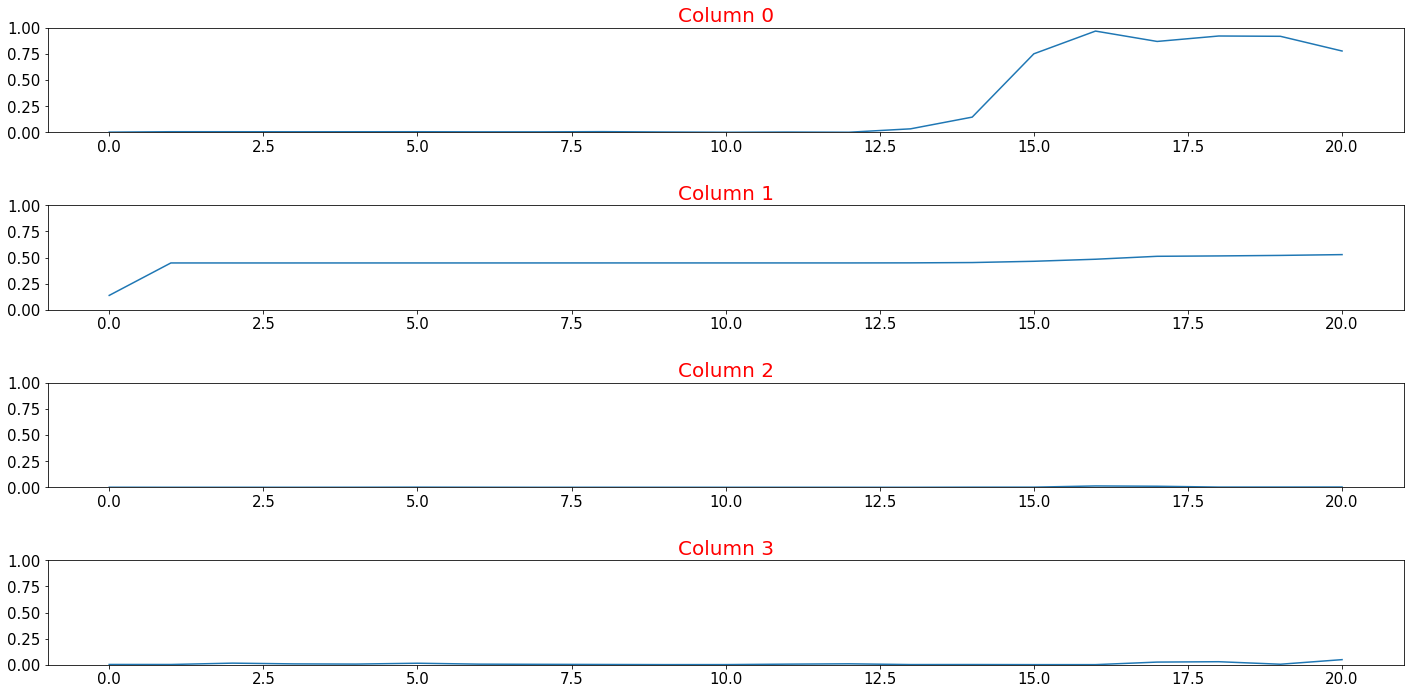

In [11]:
timeseries.plot_timeseries(X_slices[0])

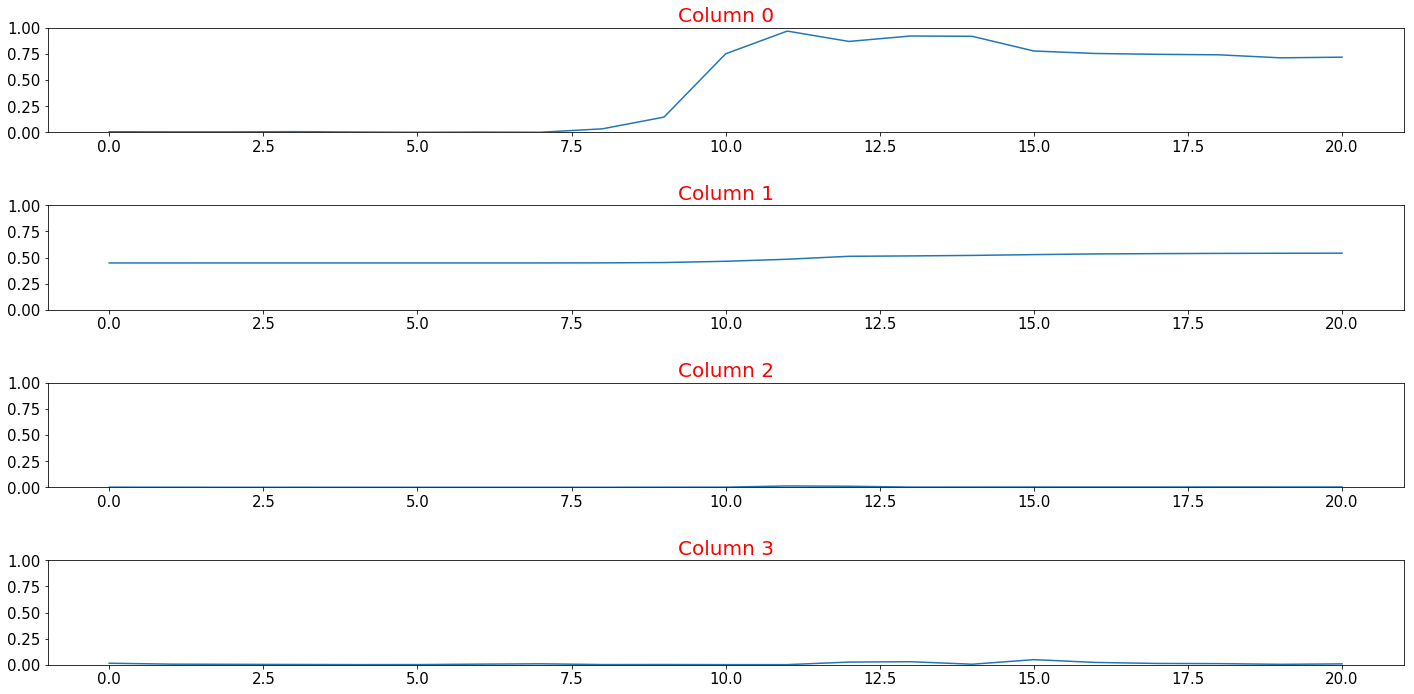

In [12]:
timeseries.plot_timeseries(X_slices[5])

In [13]:
len(X_slices)

27464

### CRBM class

### Notes on the weight initialization

A relevant aspect of learning algorithms is the initial magnitude of the weights. It turns out that the magnitude of the weights in a layer can impact the net input of the layer above and this can lead to unnexpected error. In the case of the RBM the Bernoulli hidden units generate samples acording to a logistic. Since the logistic contains an exponential this can lead to numerical problems if the numbers in the exponential are big.

#### Scaling using a fixed min-max interval

In order to facilitate introducing the problem we can start with a concrete example and generalize from there. Let us assume we have 500 visible units and 100 visible units. Let us consider a visible vector with values between 
0 and 1. Then the net input of hidden unit $i$ will be

$$
z_i = {\boldsymbol W_i} \cdot {\boldsymbol  x} + b_i
$$

If we  initialize ${\boldsymbol W_i} $ to have values in $[-0.5, 0.5]$  and $b_i=0$ then 

$$
{\boldsymbol W_i} \cdot {\boldsymbol  x}  \leq 0.5 * 1 + \dots 0.5 * 1 = 500*0.5 = 250
$$

In the worst case scenario when computing the sigmoid of that value we will have:

$$
   a_i = \frac{1}{1 + \text{e}^{-250}}
$$

We can easily run into numerical problems for the exponential of a number with "big magnitude".

#### Scaling taking into acount the number of units in the layers

Let us consider the same example as above but where we scale the weights by the maximum of the number of hidden units and visible units. In this case 500. Now all of a sudden

$$
{\boldsymbol W_i} \cdot {\boldsymbol  x}  \leq \frac{0.5}{500}  1 + \dots \frac{0.5}{500}  1 = 500 \cdot \frac{0.5}{500} = 0.5
$$

What whould happen now if we conside that we have an input layer with 100000 units? Well the maximum net input of the initial weights is ensured to be equal to the maximum value achievable in the input feature space.

$$
{\boldsymbol W_i} \cdot {\boldsymbol  x}  \leq \frac{0.5}{100000 }  1 + \dots \frac{0.5}{100000 }  1 = 100000  \cdot \frac{0.5}{100000} = 0.5
$$



In [14]:
class CRBM:
    
    def __init__(self, n_vis, n_hid, n_his,
                 seed=42, sigma=0.2, monitor_time=True, scale_factor = 0, dtype="Float32"):

        self.n_vis = n_vis
        self.n_hid = n_hid
        self.n_his = n_his
        self.seed  = seed
        self.sigma = sigma
        self.monitor_time = monitor_time
        self.scale_factor = scale_factor
        self.dtype = dtype
                    
        self.previous_xneg = None
        np.random.seed(seed)
        
        if scale_factor == 0:  #scale factor for the random initialization of the weights
            scale_factor = 1./(n_vis * n_his)
            
        if dtype == "Float32":
            dtype = np.float32
        elif dtype == "Float64":
            dtype = np.float64
        
        self.W = scale_factor * np.random.normal(0, sigma, [n_hid, n_vis]).astype(dtype)          # vis to hid
        self.A = scale_factor * np.random.normal(0, sigma, [n_vis, n_vis * n_his]).astype(dtype)  # cond to vis
        self.B = scale_factor * np.random.normal(0, sigma, [n_hid, n_vis * n_his]).astype(dtype)  # cond to hid
        self.v_bias    = np.zeros([n_vis, 1]).astype(dtype)
        self.h_bias    = np.zeros([n_hid, 1]).astype(dtype)
        self.dy_v_bias = np.zeros([n_vis, 1]).astype(dtype)
        self.dy_h_bias = np.zeros([n_hid, 1]).astype(dtype) 

        self.num_epochs_trained = 0
        self.lr = 0        
        
    def save(self, model_path, model_name):
        """
        Function to save the information contained in the class in a folder.
        The folder will contain 2 `.json` files.
        """
        
        ### Create a folder where to save models (if it does not exist) 
        if not os.path.exists(model_path):
            os.makedirs(model_path)

        ### Create a folder for the current model with name `model_name`
        model_path = os.path.join(model_path, model_name)
        if not os.path.exists(model_path):
            os.makedirs(model_path)
        else:
            print("The model {} inside folder {} already exists!".format(model_name, model_path))
            return 0

        ### Save all the information to instanciate the same model again
        arguments_init = inspect.signature(CRBM)
        init_params = {k:self.__dict__[k] for k in arguments_init.parameters.keys()} 
        
        with open( os.path.join(model_path, "model_initializer") + '.json', 'w') as outfile:
            json.dump(init_params, outfile,  ensure_ascii=False)
        
        with open( os.path.join(model_path, "model_dict") + '.pickle', 'wb') as outfile:
            pickle.dump(self.__dict__, outfile, protocol=pickle.HIGHEST_PROTOCOL)
            
    @classmethod
    def load(self, model_path):

        if not os.path.exists(model_path):
            print("The model {} does not exist!".format(model_path))
            return
            
        if not os.path.exists( os.path.join(model_path, "model_initializer.json")):
            print( "File {} is not found.".format(os.path.join(model_path, "model_initializer.json")))
            return
            
        if not os.path.exists( os.path.join(model_path, "model_dict.pickle")):
            print( "File {} is not found.".format(os.path.join(model_path, "model_dict.pickle")))
            return
            
        with open( os.path.join(model_path, "model_initializer") + '.json', 'rb') as file:
            model_initializer  = json.load(file)
    
        with open( os.path.join(model_path, "model_dict") + '.pickle', 'rb') as file:
             model_dict = pickle.load(file)
        
        crbm = CRBM(**model_initializer)
        crbm.__dict__ = model_dict

        return crbm

In [15]:
n_his = 20
n_hid = 256

In [16]:
crbm = CRBM(n_vis=n_feat, n_hid=n_hid, n_his=n_his, seed=123, sigma = 0.3);

In [17]:
#crbm.save("./saved_model_test", "crbm_")

In [18]:
#saved_crbm = CRBM.load("./saved_model_test/crbm_not_trained/")

### Auxiliary functions

In [19]:
def sig(v):
    return ne.evaluate("1/(1 + exp(-v))")

def split_vis(crbm: CRBM, vis: np.ndarray):
    n_his = vis.shape[0]
    cond = vis[0:(n_his-1), :].T
    x = vis[[n_his-1],:].T
    
    assert  crbm.n_vis == x.shape[0] and crbm.n_vis == cond.shape[0], \
            "crbm.n_vis = {}, is different from x.shape[0] = {} or cond.shape[0] = {}".format(crbm.n_vis,
                                                                                                  x.shape[0],
                                                                                                  cond.shape[0])
    return x, cond

def dynamic_biases_up(crbm: CRBM, cond: np.ndarray):
    crbm.dy_v_bias = np.dot(crbm.A, cond) + crbm.v_bias 
    crbm.dy_h_bias = np.dot(crbm.B, cond) + crbm.h_bias      
        
def hid_means(crbm: CRBM, vis: np.ndarray):
    p = np.dot(crbm.W, vis) + crbm.dy_h_bias
    return sig(p)
    
def vis_means(crbm: CRBM, hid: np.ndarray):   
    p = np.dot(crbm.W.T, hid) + crbm.dy_v_bias
    return sig(p)

In [20]:
X1 = X_train[0][0:(n_his+1), :]
X1.shape, crbm.n_his

((21, 4), 20)

In [21]:
vis, cond = split_vis(crbm, X1)
vis.shape, cond.shape

((4, 1), (4, 20))

### Compute gradients

```
function gibbs(rbm::AbstractRBM, vis::Mat; n_times=1)
    v_pos = vis
    h_pos = sample_hiddens(rbm, v_pos)
    v_neg = sample_visibles(rbm, h_pos)
    h_neg = sample_hiddens(rbm, v_neg)
    for i=1:n_times-1
        v_neg = sample_visibles(rbm, h_neg)
        h_neg = sample_hiddens(rbm, v_neg)
    end
    return v_pos, h_pos, v_neg, h_neg
end
```

In [22]:
def sample_hiddens(crbm: CRBM, v: np.ndarray, cond: np.ndarray):
    h_mean = sig( np.dot(crbm.W, v) +  np.dot(crbm.B, cond) + crbm.h_bias)
    h_sample = h_mean > np.random.random(h_mean.shape).astype(np.float32)
    return h_sample, h_mean

def sample_visibles(crbm: CRBM, h: np.ndarray, cond: np.ndarray):
    """
    Notice we don't sample or put the sigmoid here since visible units are Gaussian
    """
    v_mean = np.dot(crbm.W.T, h) + np.dot(crbm.A, cond) + crbm.v_bias  
    return v_mean

In [23]:
def CDK(crbm, vis,cond, K=1):
    v_pos_mean = vis
    h_pos_sample, h_pos_mean    = sample_hiddens(crbm,  v_pos_mean, cond)
    v_neg_mean                  = sample_visibles(crbm, h_pos_mean, cond)
    h_neg_sample, h_neg_mean    = sample_hiddens(crbm,  v_neg_mean, cond)

    for i in range(K-1):
        v_neg_mean           = sample_visibles(crbm, h_neg_mean, cond)
        h_neg, h_neg_mean    = sample_hiddens(crbm,  v_neg_mean, cond)
    
    return v_pos_mean, h_pos_mean , v_neg_mean, h_neg_mean

### Update history in matrix form

In [24]:
a = np.array([[3,3,3],[2,2,2],[1,1,1]]).T
a

array([[3, 2, 1],
       [3, 2, 1],
       [3, 2, 1]])

In [25]:
a[:,0:-1] = a[:,1:]
a

array([[2, 1, 1],
       [2, 1, 1],
       [2, 1, 1]])

In [26]:
a[:,-1] = [7,7,7]
a

array([[2, 1, 7],
       [2, 1, 7],
       [2, 1, 7]])

In [27]:
def update_history_as_mat(current_hist, vec_to_hist):
    current_hist[:,0:-1] = current_hist[:,1:]
    current_hist[:,-1] = vec_to_hist
    return current_hist

In [28]:
a = np.array([[3,3,3],[2,2,2],[1,1,1]]).T
v = np.array([7,7,7])
update_history_as_mat(a, v)

array([[2, 1, 7],
       [2, 1, 7],
       [2, 1, 7]])

### Update history in column vector form

Notice that first column in the matrix corresponds to oldest feature vector (first to be popped out):

In [29]:
a = np.array([[1,1,1,1],[2,2,2,2],[3,3,3,3],[4,4,4,4]]).T
a

array([[1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4]])

In [30]:
current_vis, hist = split_vis(crbm,a.T)
print(current_vis)
print(hist)

[[4]
 [4]
 [4]
 [4]]
[[1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]]


In [31]:
# This is what we want to do
a = np.array([a.flatten('F')]).T
a

array([[1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [2],
       [2],
       [3],
       [3],
       [3],
       [3],
       [4],
       [4],
       [4],
       [4]])

In [32]:
def update_history_as_vec(current_hist_vec, v_new):
    n_feat = v_new.shape[0]
    current_hist_vec[0:-n_feat] = current_hist_vec[n_feat:] 
    current_hist_vec[-n_feat:] = v_new
    return current_hist_vec

In [33]:
a = np.array([[1,1,1,1],[2,2,2,2],[3,3,3,3],[4,4,4,4]]).T
a = np.array([a.flatten('F')]).T
v_new = np.array([[0,0,0,0]]).T

print("original vec.T :", a.T)
print("updated vec.T:", update_history_as_vec(a, v_new).T)
print("updated vec.T:", update_history_as_vec(a, v_new).T)
print("updated vec.T:", update_history_as_vec(a, v_new).T)

original vec.T : [[1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4]]
updated vec.T: [[2 2 2 2 3 3 3 3 4 4 4 4 0 0 0 0]]
updated vec.T: [[3 3 3 3 4 4 4 4 0 0 0 0 0 0 0 0]]
updated vec.T: [[4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0]]


### Gradient computation

In [34]:
def history_mat_to_vec(cond):
    return np.array([cond.flatten('F')]).T

In [35]:
def compute_gradient(crbm, X):
    """
    Computes an approximated gradient of the likelihod (for a given minibatch X) with
    respect to the parameters. 
    """
    vis, cond = split_vis(crbm, X)
    cond = history_mat_to_vec(cond)
        
    v_pos, h_pos, v_neg, h_neg = CDK(crbm, vis, cond)
    n_obs = vis.shape[1]
    
    # for a sigle observation:  dW = h * v^T - h_hat * v_hat^T
    dW = ( np.dot(h_pos, v_pos.T) - np.dot(h_neg, v_neg.T) ) * (1./n_obs)
    dA = ( np.dot(v_pos, cond.T)  - np.dot(v_neg, cond.T)  ) * (1./n_obs)
    dB = ( np.dot(h_pos, cond.T)  - np.dot(h_neg, cond.T)  ) * (1./n_obs) 
    
    dv_bias = np.mean(v_pos - v_neg, axis=1, keepdims=True)
    dh_bias = np.mean(h_pos - h_neg, axis=1, keepdims=True)
    #print("n_obs:", n_obs)

    rec_error = np.linalg.norm(v_pos - v_neg)
    #print( np.sqrt(np.sum((v_pos - v_neg)**2)))
    
    return dW, dA, dB, dv_bias, dh_bias, rec_error

In [36]:
X = X1[0:21,:]

In [37]:
X.shape, crbm.n_his, crbm.n_vis

((21, 4), 20, 4)

In [38]:
# Notice that the history is converted to a "long column vector" concatenating
# all the rows of the n_his vectors into a single vector of `n_vis * n_his` elements.
# This is done by `cond = np.array([cond.flatten()]).T`

dW, dA, dB, dv_bias, dh_bias, rec_error = compute_gradient(crbm, X)

In [39]:
X.shape, rec_error

((21, 4), 0.97112474689850825)

### SGD  example

In [40]:
def update_weights_sgd(crbm, grads, learning_rate):
    
    dW, dA, dB, dv_bias, dh_bias = grads #rec_error = compute_gradient(crbm, X)
    crbm.W += dW * learning_rate
    crbm.A += dA * learning_rate
    crbm.B += dB * learning_rate
    
    crbm.v_bias += dv_bias * learning_rate
    crbm.h_bias += dh_bias * learning_rate
    

In [41]:
crbm = CRBM(n_vis=n_feat, n_hid=256, n_his=20, seed=123, sigma = 0.3)
learning_rate = 0.001
#import pdb;pdb.set_trace()

for i in range(10):
    dW, dA, dB, dv_bias, dh_bias, err = compute_gradient(crbm, X)
    grads  = (dW, dA, dB, dv_bias, dh_bias)
    update_weights_sgd(crbm, grads,  learning_rate)
    print("reconstruction error:", err)

reconstruction error: 0.971124746899
reconstruction error: 0.90012344431
reconstruction error: 0.834274447673
reconstruction error: 0.773207595145
reconstruction error: 0.716579151119
reconstruction error: 0.664069865977
reconstruction error: 0.615383214963
reconstruction error: 0.5702437567
reconstruction error: 0.528395637585
reconstruction error: 0.489601214724


### SGD Minibatch

In [42]:
X.shape, crbm.n_his

((21, 4), 20)

In [43]:
X.shape

(21, 4)

### Apply momentum

In [44]:
def update_weights_sgd_momentum(crbm, grads, learning_rate, ctx, momentum=0.9):
    
    dW, dA, dB, dv_bias, dh_bias = grads 
    
    ctx["W_vel"]        = ctx["W_vel"]      * momentum    +  dW      * learning_rate
    ctx["A_vel"]        = ctx["A_vel"]      * momentum    +  dA      * learning_rate
    ctx["B_vel"]        = ctx["B_vel"]      * momentum    +  dB      * learning_rate
    ctx["v_bias_vel"]   = ctx["v_bias_vel"] * momentum    +  dv_bias * learning_rate
    ctx["h_bias_vel"]   = ctx["h_bias_vel"] * momentum    +  dh_bias * learning_rate
    
    crbm.W += ctx["W_vel"]
    crbm.A += ctx["A_vel"]
    crbm.B += ctx["B_vel"]
    
    crbm.v_bias += ctx["v_bias_vel"]
    crbm.h_bias += ctx["h_bias_vel"]

In [45]:
crbm = CRBM(n_vis=n_feat, n_hid=256, n_his=20, seed=123, sigma = 0.3)
learning_rate = 0.001

ctx = { "W_vel" : np.zeros(crbm.W.shape), 
        "A_vel" : np.zeros(crbm.A.shape),
        "B_vel" : np.zeros(crbm.B.shape), 
        "v_bias_vel" : np.zeros(crbm.v_bias.shape), 
        "h_bias_vel" : np.zeros(crbm.h_bias.shape)}

for i in range(10):
    dW, dA, dB, dv_bias, dh_bias, err = compute_gradient(crbm, X)
    grads  = (dW, dA, dB, dv_bias, dh_bias)
    update_weights_sgd_momentum(crbm, grads, learning_rate, ctx, momentum=0.2)
    print("reconstruction error:", err)

reconstruction error: 0.971124746899
reconstruction error: 0.90012344431
reconstruction error: 0.820065511984
reconstruction error: 0.744009736018
reconstruction error: 0.674285008028
reconstruction error: 0.610902365157
reconstruction error: 0.553407096188
reconstruction error: 0.501283399574
reconstruction error: 0.45403993066
reconstruction error: 0.411225248892


### Get slice of data

Given a timeseries where column `k` corresponds to a feature vector for the measurements of the timeseries at time `k`, we would like to take a slice of `n_his` values to feed the CRBM with a visible vector and a history.

In [46]:
X.shape

(21, 4)

In [47]:
def get_slice_at_position_k(X, k, n_his):
    """
    Returns a slice of shape  `(n_his + 1)` with the last column beeing the visible
    vector at the current time step `k`.
    """
    assert k > n_his, "Position k = {} is lower than n_his = {}".format(k, n_his)
    assert k <= X.shape[1], "Position k = {} is bigger than number of timesteps of X.shape[1] = {}".format(k, X.shape[0])
    return X[:, (k-(n_his+1)):k]

In [48]:
#X_tr = X1.T
#print("X_tr shape: ", X_tr.shape, "\nslice shape:", get_slice_at_position_k(X_tr, 520, crbm.n_his).shape)

In [49]:
X_tr = X_train[0].T
print("X_tr shape: ", X_tr.shape, "\nslice shape:", get_slice_at_position_k(X_tr, 25, crbm.n_his).shape)

X_tr shape:  (4, 501) 
slice shape: (4, 21)


### Train some  epochs 

#### Without momentum


In [50]:
%%time
crbm = CRBM(n_vis=n_feat, n_hid=256, n_his=20, seed=123, sigma = 0.3)
n_epochs = 1
learning_rate = 0.001 # we have increased the  learning rate

for n in range(n_epochs):
    err_epoch = 0
    iters = 0
    for X_curr in X_slices:
        dW, dA, dB, dv_bias, dh_bias, rec_error = compute_gradient(crbm, X_curr)
        grads = (dW, dA, dB, dv_bias, dh_bias)
        update_weights_sgd(crbm, grads,  learning_rate)
        iters +=1
        err_epoch += rec_error
    
    print("ep {} => rec error: ".format(n), err_epoch/iters)#, end="\r")

ep 0 => rec error:  0.0282165385277
CPU times: user 25.9 s, sys: 620 ms, total: 26.5 s
Wall time: 13.5 s


#### With momentum


In [51]:
len(X_slices), X_slices[0].shape

(27464, (21, 4))

In [52]:
%%time
crbm = CRBM(n_vis=n_feat, n_hid=256, n_his=20, seed=123, sigma = 0.3)
n_epochs = 10
learning_rate = 0.001

ctx = { "W_vel" : np.zeros(crbm.W.shape), 
        "A_vel" : np.zeros(crbm.A.shape),
        "B_vel" : np.zeros(crbm.B.shape), 
        "v_bias_vel" : np.zeros(crbm.v_bias.shape), 
        "h_bias_vel" : np.zeros(crbm.h_bias.shape)}

all_errors = []

for n in range(n_epochs):
    err_epoch = 0
    iters = 0
    for X_curr in X_slices:
        dW, dA, dB, dv_bias, dh_bias, rec_error = compute_gradient(crbm, X_curr)
        grads = (dW, dA, dB, dv_bias, dh_bias)
        all_errors.append(rec_error)
        update_weights_sgd_momentum(crbm, grads, learning_rate, ctx, momentum=0.5)
        iters +=1
        err_epoch += rec_error
        
    print("rec error: ", err_epoch/iters)#, end="\r")

rec error:  0.0246840269764
rec error:  0.0239231501317
rec error:  0.023206362934
rec error:  0.0225269180431
rec error:  0.0219347473026
rec error:  0.0214429627253
rec error:  0.0210425056804
rec error:  0.0207234155464
rec error:  0.0204715528643
rec error:  0.0202708749174
CPU times: user 4min 59s, sys: 8.1 s, total: 5min 8s
Wall time: 2min 36s


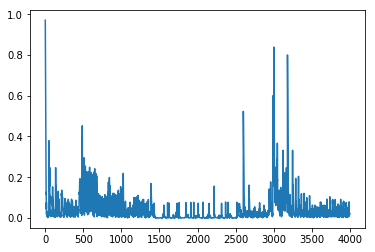

In [53]:
plt.plot(all_errors[0:4000])

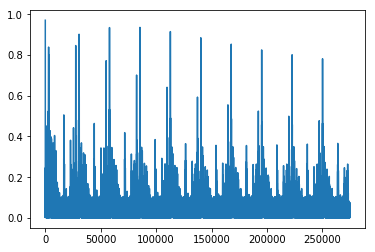

In [54]:
plt.plot(all_errors)

### Randomize examples

In [55]:
%%time
crbm = CRBM(n_vis=n_feat, n_hid=256, n_his=20, seed=123, sigma = 0.3)
n_epochs = 50
learning_rate = 0.001

ctx = { "W_vel" : np.zeros(crbm.W.shape), 
        "A_vel" : np.zeros(crbm.A.shape),
        "B_vel" : np.zeros(crbm.B.shape), 
        "v_bias_vel" : np.zeros(crbm.v_bias.shape), 
        "h_bias_vel" : np.zeros(crbm.h_bias.shape)}

rec_error_per_epoch = []
n_samples = len(X_slices)

for n in range(n_epochs):
    err_epoch = 0
    random.shuffle(X_slices)
    for X_curr in X_slices:
        dW, dA, dB, dv_bias, dh_bias, rec_error = compute_gradient(crbm, X_curr)
        grads = (dW, dA, dB, dv_bias, dh_bias)
        update_weights_sgd_momentum(crbm, grads, learning_rate, ctx, momentum=0.1)
        err_epoch += rec_error
        
    
    rec_error_per_epoch.append(err_epoch/n_samples)
    print("ep {} => rec error: ".format(n), err_epoch/n_samples,end="\r")

CPU times: user 24min 2s, sys: 37.7 s, total: 24min 40s
Wall time: 12min 26s


In [56]:
## save the model
crbm.save("./saved_models", "crbm_50_epochs")

The model crbm_50_epochs inside folder ./saved_models/crbm_50_epochs already exists!


0

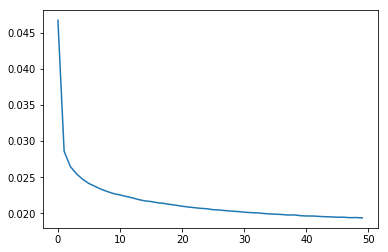

In [57]:
plt.plot(rec_error_per_epoch)

### Make predictions with the model

In [58]:
# This is a timeseries where rows are features and columns timesteps (1750 timesteps and 108 features)

#X_tr.shape, X_train[:,1].shape

In [59]:
def CDK_sa(crbm, vis,cond, K=1):
    
    v_pos_mean = vis
    h_pos_sample, h_pos_mean    = sample_hiddens(crbm,  v_pos_mean, cond)
    v_neg_mean                  = sample_visibles(crbm, h_pos_sample, cond)
    h_neg_sample, h_neg_mean    = sample_hiddens(crbm,  v_neg_mean, cond)
    
        
    for i in range(K-1):
        v_neg_mean           = sample_visibles(crbm, h_neg_sample, cond)
        h_neg, h_neg_mean    = sample_hiddens(crbm,  v_neg_mean, cond)

    return v_pos_mean, h_pos_mean , v_neg_mean, h_neg_mean

In [60]:
def generate(crbm, vis, cond_as_vec, n_gibbs=10):
    """ 
    Given initialization(s) of visibles and matching history, generate a sample in the future.
    
        vis:  n_vis * 1 array
            
        cond_as_vec: n_hist * n_vis array
            
        n_gibbs : int
            number of alternating Gibbs steps per iteration
    """
    
    assert cond_as_vec.shape[1] ==1, "cond_as_vec has to be a column vector"
    
    n_seq = vis.shape[0]
    #import pdb; pdb.set_trace()
    #v_pos, h_pos, v_neg, h_neg = CDK(crbm, vis, cond_as_vec, n_gibbs)
    v_pos, h_pos, v_neg, h_neg = CDK_sa(crbm, vis, cond_as_vec, n_gibbs)
    
    return v_neg

In [61]:
def generate_n_samples(crbm, vis, cond_as_vec, n_samples, n_gibbs=100):
    """ 
    Given initialization(s) of visibles and matching history, generate a n_samples in the future.
    """
    
    assert cond_as_vec.shape[1] ==1, "cond_as_vec has to be a column vector"
    
    samples = []
    for i in range(n_samples):
        v_new = generate(crbm, vis, cond_as_vec, n_gibbs)
        
        # This should not be here
        #v_new = v_new/np.linalg.norm(v_new)      
        #print("i:", i, "\tv_new:", v_new.T)
        #print("cond_as_vec:", cond_as_vec[-8:].T, "\n\n")
        #v_new[v_new<0] = 0
        
        update_history_as_vec(cond_as_vec, v_new)
        
        samples.append(v_new)

    return samples

#### Get data

In [62]:
X_tr = X_train[0].T
print("X_tr shape: ", X_tr.shape, "\nslice shape:", get_slice_at_position_k(X_tr, 25, crbm.n_his).shape)

X_tr shape:  (4, 501) 
slice shape: (4, 21)


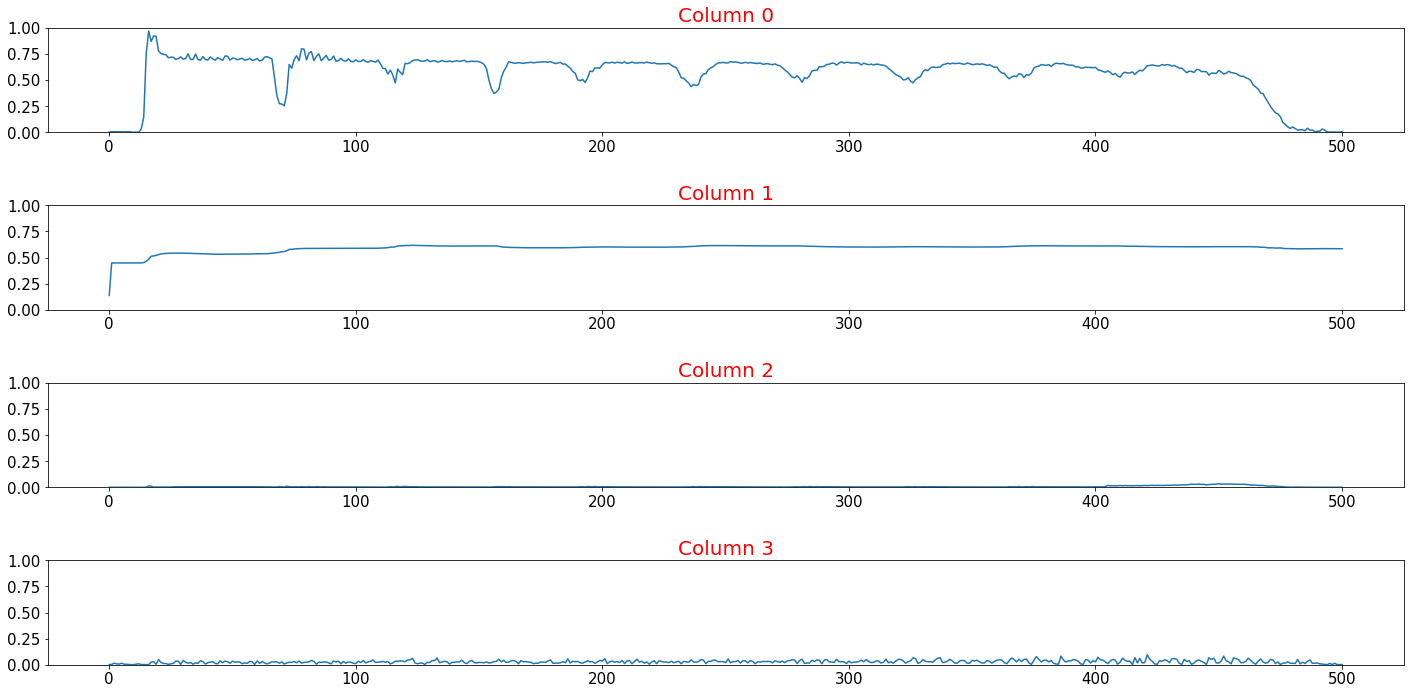

In [63]:
timeseries.plot_timeseries(X_tr.T)

### Evaluate the model making predictions given the first values of the trace

In [64]:
m = 9
X_tr = X_train[m].T

In [65]:
start_pos = 6
#v    = X_tr[:, [start_pos + crbm.n_his+1]]                         # first visible vector
hist_and_v = X_tr[:, start_pos :(start_pos +crbm.n_his+1)]          # history (features from 0 to 20)
v, cond = split_vis(crbm, hist_and_v.T)                          
cond_as_vec =  history_mat_to_vec(cond)

print("first visible vector at position: ", start_pos + crbm.n_his+1)
print(cond.shape, crbm.n_vis,  v.shape, hist.shape, X.shape)
print(v.shape, cond_as_vec.shape, crbm.n_vis, crbm.A.shape, crbm.B.shape, crbm.W.shape)
print(cond.max(), cond_as_vec.max())

n_samples = X_tr.shape[1] - crbm.n_his
samples = generate_n_samples(crbm, v, cond_as_vec, n_samples = n_samples, n_gibbs=1)
y_true = X_tr[:, crbm.n_his:n_samples].T
y_hat = np.array(samples).reshape(n_samples, n_feat)[0:(n_samples-crbm.n_his),:]

print("shapes:", y_hat.shape, y_true.shape)
print("MSE:", np.sqrt(np.mean((y_hat - y_true)**2)))

first visible vector at position:  27
(4, 20) 4 (4, 1) (4, 3) (21, 4)
(4, 1) (80, 1) 4 (4, 80) (256, 80) (256, 4)
0.467602431774 0.467602431774
shapes: (1303, 4) (1303, 4)
MSE: 0.423579273337


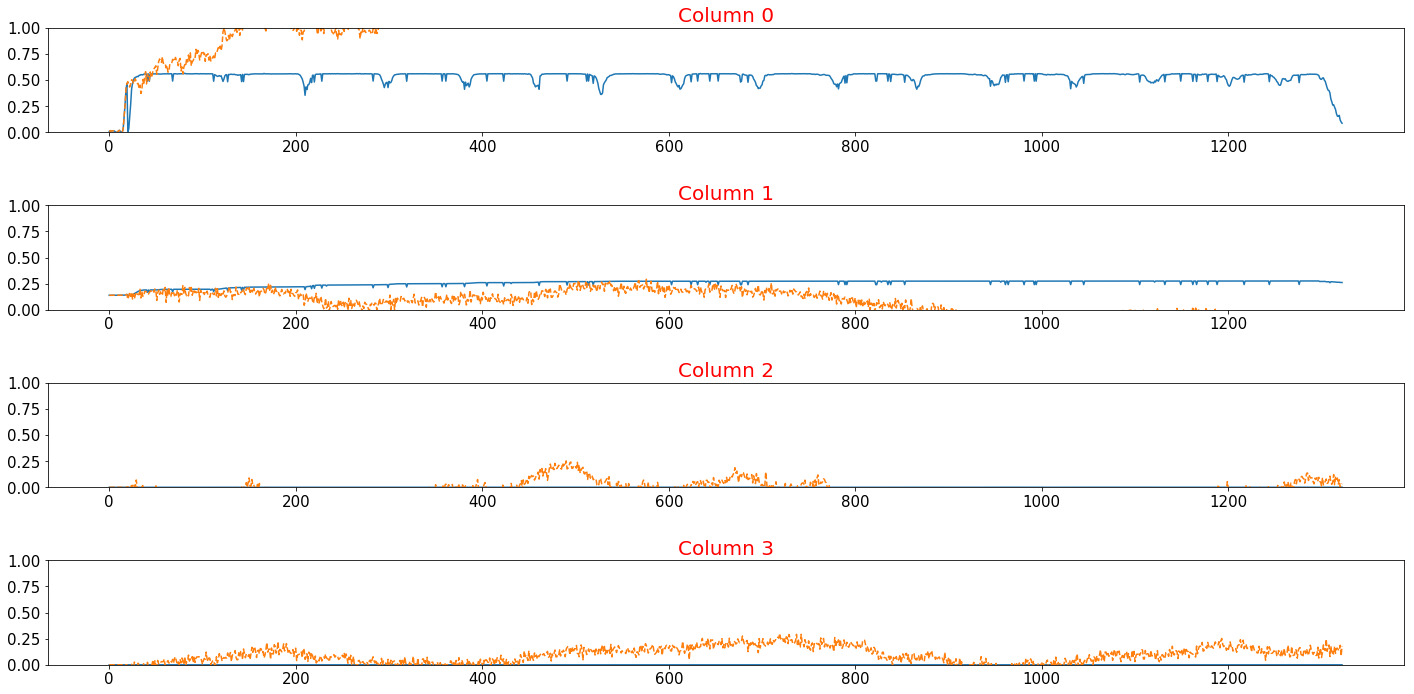

In [66]:

timeseries.plot_timeseries_overlaped(np.vstack((cond.T, y_true)),np.vstack((cond.T, y_hat)))

In [67]:
np.mean(y_hat - y_true)

0.1449036145125617

### Fer mitjana de les prediccions

In [68]:
n_predictions = 30

In [69]:
%%time
predictions = []
for i in range(n_predictions):
    cond_as_vec =  history_mat_to_vec(cond)
    samples = generate_n_samples(crbm, v, cond_as_vec, n_samples = n_samples, n_gibbs=1)
    y_hat = np.array(samples).reshape(n_samples, n_feat)[0:(n_samples-crbm.n_his),:]
    predictions.append(y_hat)

CPU times: user 13.5 s, sys: 332 ms, total: 13.8 s
Wall time: 6.96 s


In [70]:
y_hat_mean = np.array(predictions).mean(axis=0)

In [71]:
# We can impose that features below 0 take value 0 since all our data is scaled in the [0,1] range
y_hat_mean[y_hat_mean<0] = 0

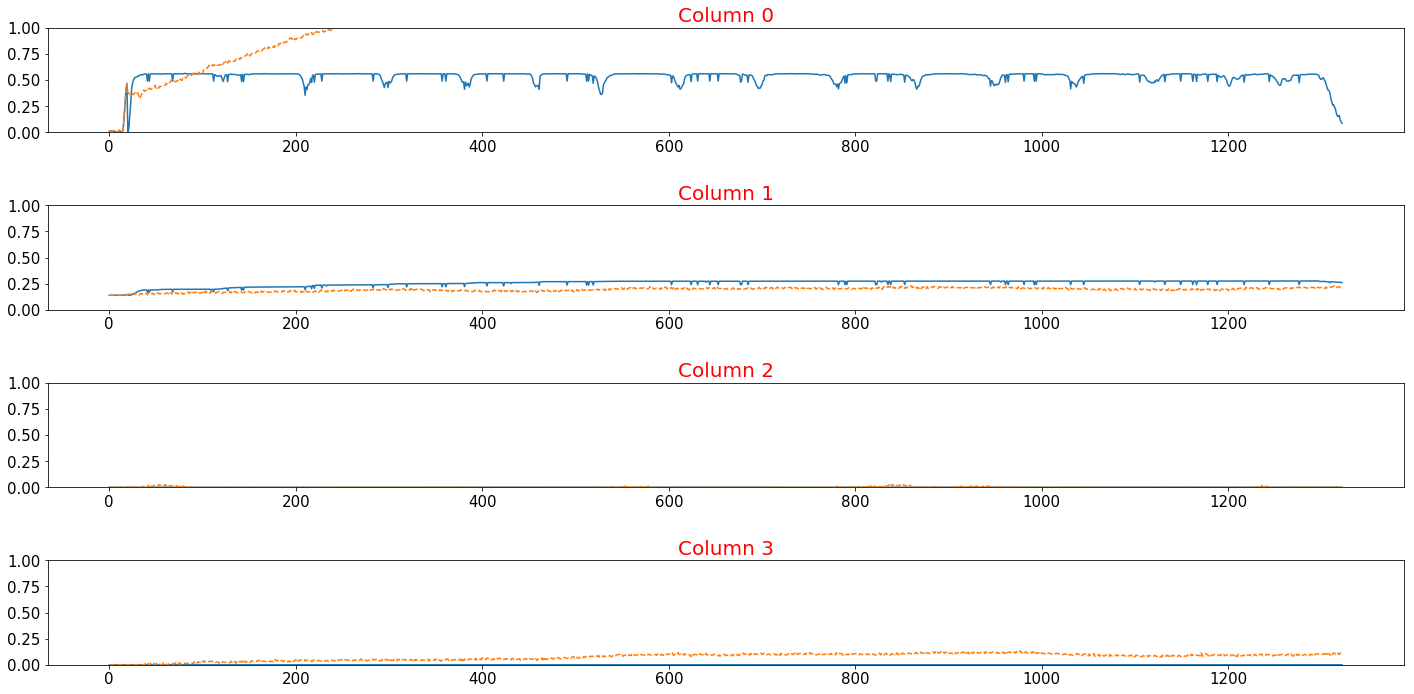

In [72]:
timeseries.plot_timeseries_overlaped(np.vstack((cond.T, y_true)),np.vstack((cond.T, y_hat_mean)))

In [73]:
np.mean(y_hat_mean - y_true)

0.21029044367529443

### Measure effect of mean predictions vs single prediction

### Persistent chain for predictions

In [74]:

def split_vis_rowdata(crbm: CRBM, vis: np.ndarray):
    n_his = vis.shape[0]
    cond = vis[0:(n_his-1), :].T
    x = vis[[n_his-1],:].T
    
    assert  crbm.n_vis == x.shape[0] and crbm.n_vis == cond.shape[0], \
            "crbm.n_vis = {}, is different from x.shape[0] = {} or cond.shape[0] = {}".format(crbm.n_vis,
                                                                                                  x.shape[0],
                                                                                                  cond.shape[0])
    return x, cond




def split_vis_coldata(crbm: CRBM, vis: np.ndarray):
    n_his = vis.shape[0]
    cond = vis[:, 0:(n_his-1)]
    x = vis[[n_his-1],:]
    
    assert  crbm.n_vis == x.shape[0] and crbm.n_vis == cond.shape[0], \
            "crbm.n_vis = {}, is different from x.shape[0] = {} or cond.shape[0] = {}".format(crbm.n_vis,
                                                                                                  x.shape[0],
                                                                                                  cond.shape[0])
    return x, cond

#### Making predictions with persistent chain

Prepare an example that trains with several data and predict feature values

```
forecast_crbm <- forecast.crbm <- function(crbm, orig_data, orig_history = NULL, n_samples = 10, n_gibbs = 30)
{
	if (is.null(orig_history))
	{
		l <- nrow(orig_data);
		orig_history <- orig_data[l - 1:crbm$delay,, drop=FALSE];
		orig_history <- array(t(orig_history), c(1, crbm$n_visible * crbm$delay));
		orig_data <- orig_data[l,, drop = FALSE];
		n_seq <- 1;
	} else {
		n_seq <- nrow(orig_data);
	}
	
	persistent_vis_chain <<- orig_data;
	persistent_history <<- orig_history;

    # construct the function that implements our persistent chain.
	sample_fn <- function(crbm, n_gibbs)
	{
		vis_sample <- persistent_vis_chain;
		v_history <- persistent_history;

		vis_mf <- NULL;
		for (k in 1:n_gibbs)
		{
			hid <- sample_h_given_v_crbm(crbm, vis_sample, v_history);
			vis <- sample_v_given_h_crbm(crbm, hid[["sample"]], v_history);

			vis_mf <- vis[["mean"]];
			vis_sample <- vis[["sample"]];
		}

		# add to updates the shared variable that takes care of our persistent chain
		persistent_vis_chain <<- vis_sample;
		persistent_history <<- cbind(vis_sample, persistent_history[,1:((crbm$delay - 1) * crbm$n_visible), drop = FALSE]);

		vis_mf;
	}

	generated_series <- array(0,c(n_seq, n_samples, crbm$n_visible));
	for (t in 1:n_samples)
	{
		#if (t %% 10 == 1) print(paste("Generating frame ", t, " to ", min(t+9, n_samples), sep = ""));
		generated_series[,t,] <- sample_fn(crbm, n_gibbs);
	}
	generated_series;
}
```

In [75]:
def generate_persistent(crbm, orig_data, orig_hist, n_samples, n_gibbs=10):
    """ 
    Given initialization(s) of visibles and matching history, generate n_samples in future.
    
        orig_data : n_seq by n_visibles array
            initialization for first frame
            
        orig_history : n_seq by delay * n_visibles array
            delay-step history
            
        n_samples : int
            number of samples to generate forward
            
        n_gibbs : int
            number of alternating Gibbs steps per iteration
    """
    n_seq = orign_data.shape[0]
    persistent_vis_chain = None
    persistent_history   = None
    
    return generated_series

### Plot predictions